In [1]:
# 前処理
import nltk
from nltk.tokenize import wordpunct_tokenize, sent_tokenize
# ＜使用しているNLTKライブラリの説明＞
# nltk.corpus.stopwords: 文章を特徴付ける要素として不適切なものを除外するためのブラックリスト。通称ストップワード。
# nltk.sent_tokenize: 文章(doc)を文(sentence)に分割する。
# nltk.wordpunct_tokenize: 文(sentence)を単語(word)に分割する。通称トークン化。
# nltk.lemmatize: 単語(word)を基本形(らしきもの)に修正する。通称ステミング。

import numpy as np   

In [2]:
from lxml import html

In [5]:
filepath = "ch"
remove_tags = ('.//style', './/script', './/noscript')
#文章の取得と整形
docs3 = [''] * 13
for i in range(0,13):
    with open(filepath +str(i)+".html" , mode='rb') as f:#文章読み込み
        docs3[i] = html.fromstring(f.read())
        for remove_tag in remove_tags:
            for tag in docs3[i].findall(remove_tag):#各タグの除去
                tag.drop_tree()
        docs3[i] = docs3[i].text_content().strip()

#docs2 = preprocess_docs(docs3)

In [6]:
import scipy.spatial.distance as distance

# BoW

# 文書集合からターム素性集合（コードブック）を作る
def collect_words_eng(docs):
    '''英文書集合から単語コードブック作成。
    シンプルに文書集合を予め決めうちした方式で処理する。
    必要に応じて指定できるようにしていた方が使い易いかも。

    :param docs(list): 1文書1文字列で保存。複数文書をリストとして並べたもの。
    :return (list): 文分割、単語分割、基本形、ストップワード除去した、ユニークな単語一覧。
    '''
    codebook = []
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.append('.')   # ピリオドを追加。
    stopwords.append(',')   # カンマを追加。
    stopwords.append('')    # 空文字を追加。
    stopwords.append('!')
    stopwords.append('?')
    wnl = nltk.stem.wordnet.WordNetLemmatizer()
    for doc in docs:
        for sent in sent_tokenize(doc):
            for word in wordpunct_tokenize(sent):
                this_word = wnl.lemmatize(word.lower())
                if this_word not in codebook and this_word not in stopwords:
                    codebook.append(this_word)
    return codebook

codebook = collect_words_eng(docs3)
#print('codebook = ',codebook)

In [7]:
# コードブックを素性とする文書ベクトルを作る (直接ベクトル生成)
def make_vectors_eng(docs, codebook):
    '''コードブックを素性とする文書ベクトルを作る（直接ベクトル生成）

    :param docs(list): 1文書1文字列で保存。複数文書をリストとして並べたもの。
    :param codebook(list): ユニークな単語一覧。
    :return (list): コードブックを元に、出現回数を特徴量とするベクトルを返す。
    '''
    vectors = []
    wnl = nltk.stem.wordnet.WordNetLemmatizer()
    for doc in docs:
        this_vector = []
        fdist = nltk.FreqDist()
        for sent in sent_tokenize(doc):
            for word in wordpunct_tokenize(sent):
                this_word = wnl.lemmatize(word.lower())
                fdist[this_word] += 1
        for word in codebook:
            this_vector.append(fdist[word])
        vectors.append(this_vector)
    return vectors

vectors = make_vectors_eng(docs3, codebook)

#以下確認文出力は非常に長いので省略
#for index in range(len(docs3)):
#    print('docs[{}] = {}'.format(index,docs3[index]))
#    print('vectors[{}] = {}'.format(index,vectors[index]))
#    print('----')

In [8]:
def euclidean_distance(vectors):
    vectors = np.array(vectors)
    distances = []
    for i in range(len(vectors)):
        temp = []
        for j in range(len(vectors)):
            temp.append(np.linalg.norm(vectors[i] - vectors[j]))
        distances.append(temp)
    return distances

def cosine_similarity(vectors):
    vectors = np.array(vectors)
    distances = []
    for i in range(len(vectors)):
        temp = []
        for j in range(len(vectors)):
            temp.append(round(1-distance.cosine(vectors[i], vectors[j]),3))
        distances.append(temp)
    return distances



# normal BoW
[1.0, 0.505, 0.336, 0.397, 0.439, 0.281, 0.237, 0.231, 0.201, 0.133, 0.238, 0.417, 0.693]
[0.505, 1.0, 0.622, 0.718, 0.713, 0.479, 0.357, 0.279, 0.27, 0.139, 0.263, 0.394, 0.351]
[0.336, 0.622, 1.0, 0.611, 0.57, 0.517, 0.338, 0.308, 0.26, 0.13, 0.213, 0.467, 0.273]
[0.397, 0.718, 0.611, 1.0, 0.655, 0.459, 0.302, 0.33, 0.268, 0.154, 0.265, 0.447, 0.284]
[0.439, 0.713, 0.57, 0.655, 1.0, 0.458, 0.347, 0.291, 0.271, 0.185, 0.314, 0.419, 0.28]
[0.281, 0.479, 0.517, 0.459, 0.458, 1.0, 0.38, 0.528, 0.267, 0.172, 0.226, 0.376, 0.253]
[0.237, 0.357, 0.338, 0.302, 0.347, 0.38, 1.0, 0.308, 0.218, 0.242, 0.237, 0.299, 0.242]
[0.231, 0.279, 0.308, 0.33, 0.291, 0.528, 0.308, 1.0, 0.508, 0.277, 0.284, 0.325, 0.217]
[0.201, 0.27, 0.26, 0.268, 0.271, 0.267, 0.218, 0.508, 1.0, 0.401, 0.326, 0.279, 0.221]
[0.133, 0.139, 0.13, 0.154, 0.185, 0.172, 0.242, 0.277, 0.401, 1.0, 0.268, 0.159, 0.14]
[0.238, 0.263, 0.213, 0.265, 0.314, 0.226, 0.237, 0.284, 0.326, 0.268, 1.0, 0.227, 0.284]
[0.417, 0.3

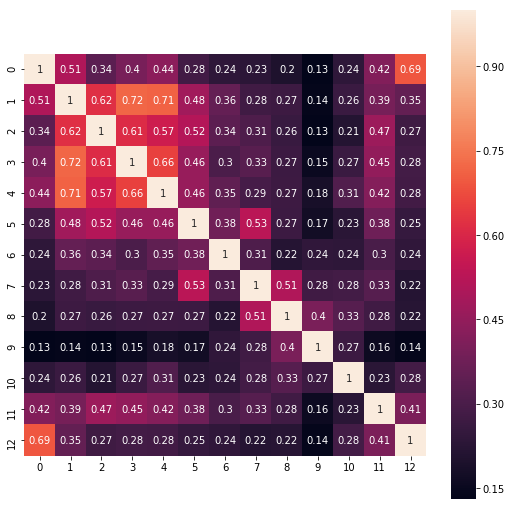

In [11]:
import sklearn.feature_extraction.text as fe_text
import matplotlib.pyplot as plt
import seaborn as sns

def bow(docs):
    '''Bag-of-Wordsによるベクトルを生成。

    :param docs(list): 1文書1文字列で保存。複数文書をリストとして並べたもの。
    :return: 文書ベクトル。
    '''
    vectorizer = fe_text.CountVectorizer(stop_words='english')
    vectors = vectorizer.fit_transform(docs)
    return vectors.toarray(), vectorizer

vectors, vectorizer = bow(docs3)
#Level1の結果出力
print('# normal BoW')
#print(vectorizer.get_feature_names())
#print(vectors)
similarities = cosine_similarity(vectors)

for index in range(len(similarities)):
    print(similarities[index])
  
fig, ax =plt.subplots(figsize=(9, 9))


sns.heatmap((similarities), ax=ax,annot=True,square=True)
ax.set_ylim(len(similarities), 0)
plt.show()



# BoW + tfidf
[1.0, 0.369, 0.223, 0.29, 0.335, 0.186, 0.163, 0.134, 0.125, 0.069, 0.135, 0.255, 0.503]
[0.369, 1.0, 0.434, 0.537, 0.549, 0.305, 0.22, 0.151, 0.161, 0.07, 0.146, 0.227, 0.232]
[0.223, 0.434, 1.0, 0.418, 0.409, 0.316, 0.2, 0.157, 0.143, 0.064, 0.107, 0.282, 0.163]
[0.29, 0.537, 0.418, 1.0, 0.506, 0.294, 0.185, 0.186, 0.162, 0.078, 0.146, 0.277, 0.183]
[0.335, 0.549, 0.409, 0.506, 1.0, 0.309, 0.219, 0.169, 0.182, 0.113, 0.18, 0.268, 0.192]
[0.186, 0.305, 0.316, 0.294, 0.309, 1.0, 0.242, 0.415, 0.16, 0.092, 0.112, 0.207, 0.149]
[0.163, 0.22, 0.2, 0.185, 0.219, 0.242, 1.0, 0.197, 0.123, 0.113, 0.108, 0.149, 0.152]
[0.134, 0.151, 0.157, 0.186, 0.169, 0.415, 0.197, 1.0, 0.365, 0.163, 0.151, 0.165, 0.112]
[0.125, 0.161, 0.143, 0.162, 0.182, 0.16, 0.123, 0.365, 1.0, 0.304, 0.197, 0.152, 0.14]
[0.069, 0.07, 0.064, 0.078, 0.113, 0.092, 0.113, 0.163, 0.304, 1.0, 0.164, 0.074, 0.071]
[0.135, 0.146, 0.107, 0.146, 0.18, 0.112, 0.108, 0.151, 0.197, 0.164, 1.0, 0.108, 0.176]
[0.255, 0.2

<Figure size 432x288 with 0 Axes>

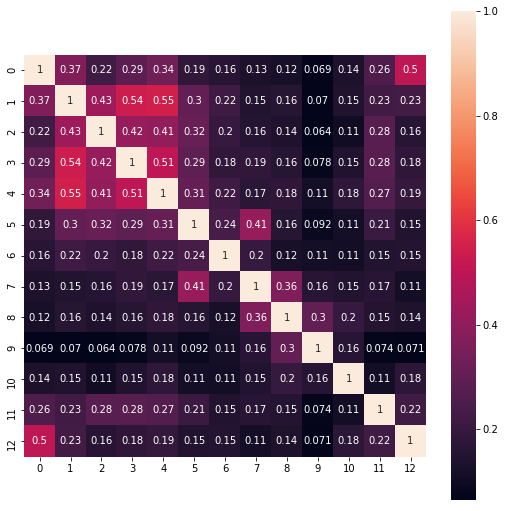

In [12]:
def bow_tfidf(docs):
    '''Bag-of-WordsにTF-IDFで重み調整したベクトルを生成。

    :param docs(list): 1文書1文字列で保存。複数文書をリストとして並べたもの。
    :return: 重み調整したベクトル。
    '''
    vectorizer = fe_text.TfidfVectorizer(norm=None, stop_words='english')
    vectors = vectorizer.fit_transform(docs)
    return vectors.toarray(), vectorizer

vectors, vectorizer = bow_tfidf(docs3)

#Level2の結果出力
print('# BoW + tfidf')
similarities = cosine_similarity(vectors)

for index in range(len(similarities)):
    print(similarities[index])
    
plt.figure()

fig, ax =plt.subplots(figsize=(9, 9))

sns.heatmap((similarities), ax=ax,annot=True,square=True)
ax.set_ylim(len(similarities), 0)
plt.show()

In [13]:
import pandas as pd

sentence = docs3[0]+docs3[1]+docs3[2]+docs3[3]+docs3[4]+docs3[5]+docs3[6]+docs3[7]+docs3[8]+docs3[9]+docs3[10]+docs3[11]+docs3[12]
#print(sentence)
#print('len(sentence) = ', len(sentence))


def preprocess(text):
    """テキストに対する前処理。
    「ゼロから作るDeepLearning2 自然言語処理辺」p.66より。

    :param text:
    :return:
      courpus(list): id_to_wordのidに基づいたone-hot vector。
      word_to_id(dict): 単語をkeyとして、idを参照する辞書。
      id_to_word(dict): idをkeyとして、単語を参照する辞書。
    """
    text = text.lower()
    text = text.replace('.', ' .')
    text = text.replace('"', '')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    corpus = np.array([word_to_id[w] for w in words])
    return corpus, word_to_id, id_to_word

corpus, word_to_id, id_to_word = preprocess(sentence)
vocab_size = len(word_to_id)

#以下の出力文は長いので省略
#print(corpus)
#print(word_to_id)
#print(id_to_word)

In [14]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    """共起行列を作成。
    「ゼロから作るDeepLearning2 自然言語処理辺」p.72より。

    :param corpus(str): テキスト文。
    :param vocab_size: 語彙数。
    :param window_size: 共起判定の範囲。
    :return:
    """
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size+1):
            left_idx = idx - i
            right_idx = idx + i
            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
    return co_matrix

co_matrix = create_co_matrix(corpus, vocab_size, window_size=13)
df = pd.DataFrame(co_matrix, index=word_to_id.keys(), columns=word_to_id.keys())
df

,preface preface this,is,a,book,about,natural,language,processing,.,by,...,end: as,algorithms for,"text, as",serve the,"society, and",pathway,riches of,present:,hacking! about,acst
preface\n\n\n\n\npreface\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nthis,0,1,2,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
is,1,884,1802,27,60,54,114,46,1501,210,...,0,0,0,0,0,0,0,1,1,0
a,2,1802,3422,41,86,62,193,87,2682,426,...,2,3,1,2,1,1,1,0,1,0
book,1,27,41,10,6,4,9,4,46,10,...,0,0,0,0,0,0,0,0,0,0
about,1,60,86,6,26,4,11,6,106,23,...,0,0,0,0,0,0,0,0,0,0
natural,1,54,62,4,4,8,100,30,76,7,...,0,0,0,0,0,0,0,0,0,0
language,1,114,193,9,11,100,70,62,168,23,...,0,0,1,1,2,2,1,1,1,0
processing,1,46,87,4,6,30,62,12,63,10,...,0,0,0,0,0,0,0,0,0,0
.,1,1501,2682,46,106,76,168,63,10332,383,...,0,0,0,0,0,0,2,2,2,0
by,1,210,426,10,23,7,23,10,383,94,...,0,0,0,0,0,0,0,0,0,0


In [15]:
def cos_similarity(x, y, eps=1e-8):
    nx = x / (np.sqrt(np.sum(x ** 2)) + eps)
    ny = y / (np.sqrt(np.sum(y ** 2)) + eps)
    return np.dot(nx, ny)

def similar(query, word_to_id, id_to_word, word_matrix, top=5):
    """
    list内の各単語の単語間類似度を出力
    :param query(str): クエリ。
    :param word_to_id(dict): 単語をkeyとして、idを参照する辞書。
    :param id_to_word(dict): idをkeyとして、単語を参照する辞書。
    :param word_matrix: 共起行列。
    :param top(int): 上位何件まで表示させるか。今回は使用しない
    :return: なし。
    """
    if query not in word_to_id:
        print('%s is not found' % query)
        return
    
    result = []
    print('[query] ' + query +" language" + " text"+ " write"+" count")
    list=["natural","language","text","write","count"]#調べる単語
    for x in range(0,5):
        query_id = word_to_id[list[x]]
        query_vec = word_matrix[query_id]
        
        vocab_size = len(word_to_id)
        similarity = np.zeros(vocab_size)
        print(list[x]+" ", end="")
        tmp=[]
        for i in range(vocab_size):
            natural=0
            language=0
            text=0
            count=0
            write=0
            similarity[i] = cos_similarity(word_matrix[i], query_vec)
            if  id_to_word[i] == "natural":
                tmp.append(round(similarity[i],3))
            if  id_to_word[i] == "language":
                tmp.append(round(similarity[i],3))
            if  id_to_word[i] == "text":
                tmp.append(round(similarity[i],3))
            if  id_to_word[i] == "count":
                tmp.append(round(similarity[i],3))
            if  id_to_word[i] == "write":
                tmp.append(round(similarity[i],3))
        
        result.append(tmp)
        print(result[x])


#Level3結果出力
print('\n# similar() with co_matrix')
user_query = "natural"
similar(user_query, word_to_id, id_to_word, co_matrix)


# similar() with co_matrix
[query] natural language text write count
natural [1.0, 0.91, 0.771, 0.738, 0.687]
language [0.91, 1.0, 0.904, 0.869, 0.821]
text [0.771, 0.904, 1.0, 0.92, 0.934]
write [0.738, 0.869, 0.92, 1.0, 0.827]
count [0.687, 0.821, 0.934, 0.827, 1.0]


In [16]:
from sklearn.datasets import fetch_20newsgroups

In [17]:
newsgroups_train = fetch_20newsgroups(subset='train')
from pprint import pprint 
pprint(list(newsgroups_train.target_names))#全カテゴリーの表示

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
categories = ['alt.atheism', 'talk.religion.misc']#取得するカテゴリー
newsgroups_train = fetch_20newsgroups(subset='train',
                                       categories=categories)#訓練データ取得
newsgroups_test = fetch_20newsgroups(subset='test',
                                       categories=categories)#テストデータ取得
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newsgroups_train.data)
vectors.shape


(857, 18089)

In [19]:
vectors.nnz / float(vectors.shape[0])

176.6382730455076

In [20]:
# BoW + tfidfの適応
vectors, vectorizer = bow_tfidf(newsgroups_train.data)#訓練データとテストデータの適応

In [21]:
from sklearn import svm
from sklearn import metrics
# SVMの学習
classifier = svm.LinearSVC(dual=False)#分類器
classifier.fit(vectors , newsgroups_train.target)

vectors_test = vectorizer.transform(newsgroups_test.data)
# 予測
pred = classifier.predict(vectors_test)

#Level4出力
metrics.f1_score(newsgroups_test.target, pred, average='macro')#精度表示

0.8372419272740816

In [22]:
# Plot non-normalized confusion matrix
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

Confusion matrix, without normalization
[[265  54]
 [ 38 213]]
Normalized confusion matrix
[[0.830721   0.169279  ]
 [0.15139442 0.84860558]]


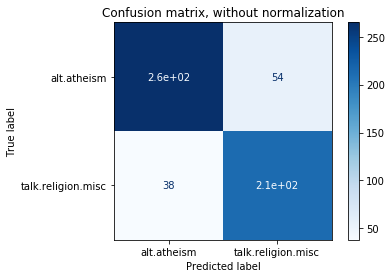

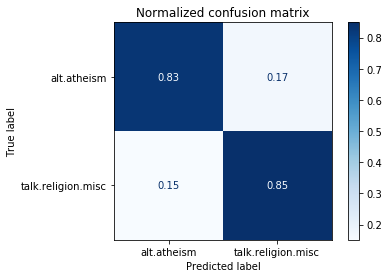

In [23]:
class_names = categories
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(classifier, vectors_test, newsgroups_test.target,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()